In [24]:
# imports
from dotenv import load_dotenv
import os
import re
import math
from tqdm import tqdm
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datetime import datetime
import pickle
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [2]:
# Log in to HuggingFace
load_dotenv(override=True)
os.environ['HUGGINGFACE_RW_TOKEN'] = os.getenv('HUGGINGFACE_RW_TOKEN', 'your-key-if-not-using-env')
hf_token = os.environ['HUGGINGFACE_RW_TOKEN']
login(hf_token, add_to_git_credential=True)

In [3]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [4]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
DATASET_NAME = f"ed-donner/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [6]:
investigate_tokenizer(LLAMA_3_1)

Investigating tokenizer for meta-llama/Meta-Llama-3.1-8B
The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [605]
The tokens for 100: [1041]
The tokens for 999: [5500]
The tokens for 1000: [1041, 15]


In [30]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [15]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00',
 'price': 226.95}

In [17]:
if QUANT_4_BIT:
    quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
    quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [18]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


In [19]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [20]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [21]:
model_predict(test[0]['text'])

1800.0

In [22]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $1,800.00 Truth: $374.41 Error: $1,425.59 SLE: 2.46 Item: OEM AC Compressor w/...
2: Guess: $25.00 Truth: $225.11 Error: $200.11 SLE: 4.68 Item: Motorcraft YB3125 Fa...
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman Front Washer ...
4: Guess: $1,999.00 Truth: $599.99 Error: $1,399.01 SLE: 1.45 Item: HP Premium HD Plus T...
5: Guess: $7.50 Truth: $16.99 Error: $9.49 SLE: 0.56 Item: Super Switch Pickup ...
6: Guess: $1.00 Truth: $31.99 Error: $30.99 SLE: 7.86 Item: Horror Bookmarks, Re...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 G...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $299.00 Truth: $635.86 Error: $336.86 SLE: 0.57 Item: Randall G3 Plus Comb...
10: Guess: $25.99 Truth: $65.99 Error: $40.00 SLE: 0.83 Item: HOLDWILL 6 Pack LED ...
11: Guess: $110.00 Truth: $254.21 Error: $144.21 SLE: 0.69 Item: Viking Horns 3 Gallo...
12: Guess: $1,800.00 Truth: $412.99 Error

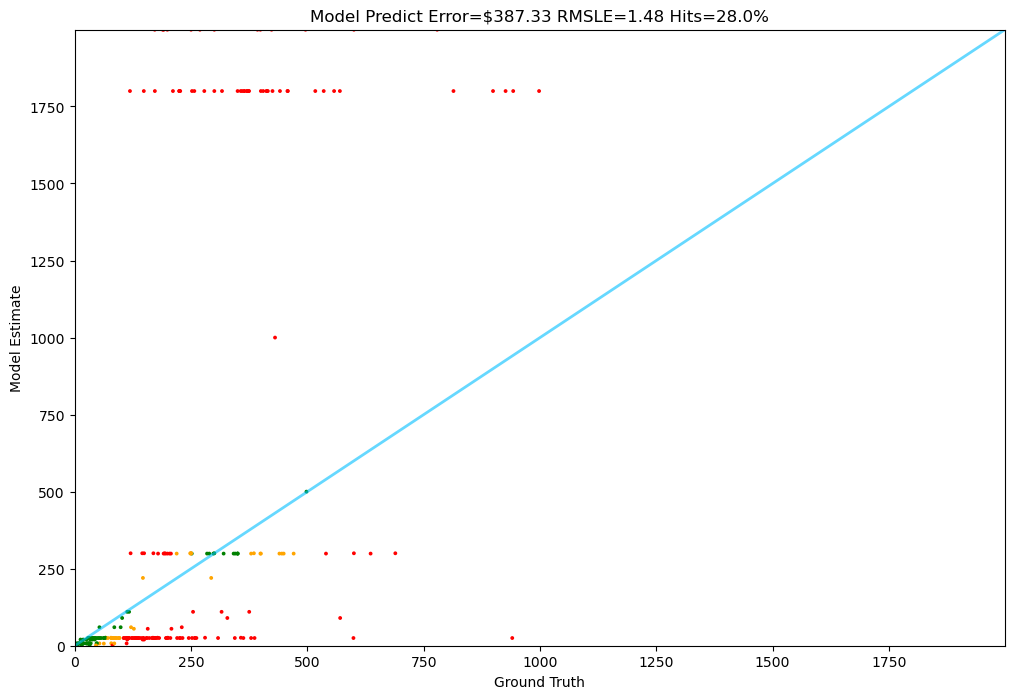

In [25]:
Tester.test(model_predict, test)